In [214]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression, BayesianRidge, LogisticRegression
from scipy.stats import norm

<h1> 1.

In [82]:
df = pd.read_csv("owid-covid-data.csv")

In [83]:
df = df[df['location']=='Russia']

In [84]:
df.reset_index(drop=True, inplace=True)
df['new_cases'] = df['new_cases'].apply(lambda x: 1 if x==0 else x)

In [85]:
#train test разбиение
train = df[df['location']=='Russia'][63:113].reset_index(drop=True)
test = df[df['location']=='Russia'][113:].set_index(np.arange(50, 74))

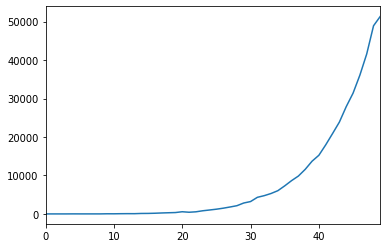

In [86]:
(train['total_cases']+train['new_cases']).plot(kind='line')

<h1> 2.

In [174]:
#фит линейной регрессии на ln(train)
reg = LinearRegression()
reg.fit(np.array((train['total_cases']).index).reshape(-1, 1), 
           np.log(train['total_cases']+train['new_cases']))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [175]:
#Найдем значение дисперсии из модели на train, там защито предположение о равенстве дисперсий
standart_deviation = np.std(reg.predict(np.array((train['total_cases']).index).reshape(-1, 1)) - \
       np.log(train['total_cases']+train['new_cases']))

standart_deviation**2

0.1434462348874815

In [176]:
#Теперь посчитаем апостериорное распределение
#Для этого сначала посчитаем правдоподобие
def make_normal_distribution(mean_, std_):
    x = np.linspace(-100.0, 100.0, 1000000)
    y = norm.pdf(x, mean_, std_**2)
    return y

def calc_likelyhood(preds, std_=standart_deviation):
    temp2 = make_normal_distribution(preds[0], std_)
    for i in range(1, len(preds)):
        temp1 = make_normal_distribution(preds[i], std_)
        temp2 = temp1 * temp2
        temp2 = ((temp1.sum() + temp2.sum()) / 2.0) * (temp2.astype(float) / temp2.astype(float).sum())
    return temp2

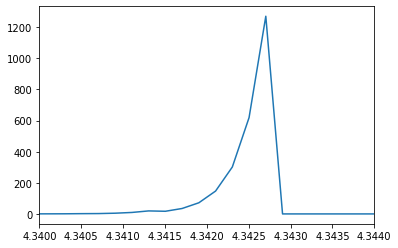

In [177]:
#Так выглядит распределению правдоподобия
plt.xlim(4.34,4.344)
plt.plot(np.linspace(-100.0, 100.0, 1000000), calc_likelyhood(reg.predict(np.array((train['total_cases'][:41]).index).reshape(-1, 1))))

<h2> Это оказалось лишним, на лекции же был вывод формулы :(

In [180]:
predicted_train = reg.predict(np.array((train['total_cases']).index).reshape(-1, 1))
predicted_train

array([ 1.71326093,  1.91389413,  2.11452734,  2.31516054,  2.51579375,
        2.71642695,  2.91706016,  3.11769337,  3.31832657,  3.51895978,
        3.71959298,  3.92022619,  4.12085939,  4.3214926 ,  4.5221258 ,
        4.72275901,  4.92339221,  5.12402542,  5.32465862,  5.52529183,
        5.72592504,  5.92655824,  6.12719145,  6.32782465,  6.52845786,
        6.72909106,  6.92972427,  7.13035747,  7.33099068,  7.53162388,
        7.73225709,  7.93289029,  8.1335235 ,  8.33415671,  8.53478991,
        8.73542312,  8.93605632,  9.13668953,  9.33732273,  9.53795594,
        9.73858914,  9.93922235, 10.13985555, 10.34048876, 10.54112196,
       10.74175517, 10.94238838, 11.14302158, 11.34365479, 11.54428799])

In [181]:
actual_train_log = np.log(np.array((train['total_cases']+train['new_cases'])))
actual_train_log

array([ 1.38629436,  1.60943791,  1.60943791,  1.60943791,  2.77258872,
        2.39789527,  2.39789527,  2.39789527,  2.39789527,  3.68887945,
        3.55534806,  4.09434456,  4.29045944,  4.20469262,  4.81218436,
        4.90527478,  5.19295685,  5.52545294,  5.72684775,  5.88332239,
        6.34563636,  6.08449941,  6.31354805,  6.71052311,  6.92951677,
        7.11639414,  7.30787278,  7.4977617 ,  7.66762609,  7.95085486,
        8.07620453,  8.37077917,  8.4658999 ,  8.57791193,  8.70731756,
        8.89521858,  9.0654302 ,  9.19492212,  9.35789794,  9.52537007,
        9.63240035,  9.7956796 ,  9.94683436, 10.08062905, 10.23559313,
       10.35411721, 10.49343854, 10.63532646, 10.79779849, 10.84717942])

In [182]:
Theta_new = 1 / (standart_deviation + 1/(standart_deviation**2)*predicted_train.dot(predicted_train))
mu_new = 1 / Theta_new * \
(standart_deviation * 0 + 1 / standart_deviation**2 * predicted_train.dot(actual_train_log))

In [183]:
1 / Theta_new

18238.389794504124

In [184]:
Theta_new

5.482940167784634e-05

In [185]:
mu_new

332631954.63441205

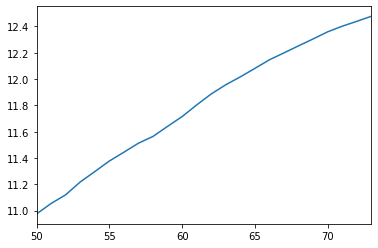

In [186]:
#Реальная логарифмическая прямая на test
pd.Series(np.log(test['total_cases']+test['new_cases'])).plot(kind='line')

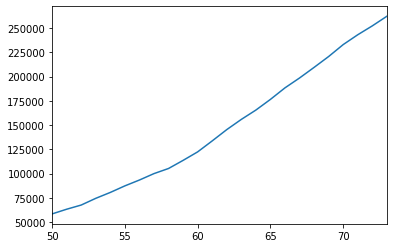

In [187]:
#Реальные данные на тесте
(test['total_cases']+test['new_cases']).plot(kind='line')

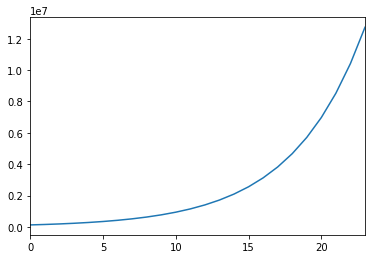

In [188]:
#Экспонециированный предикт на тесте
pd.Series(np.exp(reg.predict(np.array((test['total_cases']).index).reshape(-1, 1)))).plot(kind='line')

<h1> 3.

<h5> Подбирать параметры сигмоидной функции с помощью линейной можно, воспользовавшись logistic function:

In [269]:
def sigmoid(x):
    return ((train['total_cases']+train['new_cases']).mean() - 1000)/(1 + np.exp(-x))

#Пробую "сместить" вверх сигмоидное преобразование на среднее 

In [264]:
def inverse_sigmoid(x):
    return -np.log((train['total_cases']+train['new_cases']).mean() - 1000 / x - 1)

In [265]:
(train['total_cases']+train['new_cases']).mean()

8090.84

In [266]:
#фит линейной регрессии на sigmoid(train)
reg = LinearRegression()
reg.fit(np.array((train['total_cases']).index).reshape(-1, 1), 
           sigmoid(train['total_cases']+train['new_cases']))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)